In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# PolicyTree and PolicyForest

These are basic tree and forest classes, that accept `X, y` where `y` is `(n_samples, n_outputs)` and
trains a tree to maximize the linear welfare criterion: `<f(X), y>`, where the maximization is over functions from `X` to `{e_1, ..., e_{n_outputs}}`, representable by either a tree or a forest. The `predict` method returns the coordinate that achieves the maximum `y[i]` for each `X` based on the tree policy. The `predict_value` method returns the conditional mean value of all coordinates, conditional on `X`, for the leaf that `X` falls in. These classes can be used as building blocks for other functionalities, such as the `SingleTreePolicyInterpreter` or the `DRPolicyTree` or `DRPolicyForest`.

In [3]:
from econml.policy import PolicyTree, PolicyForest

In [4]:
X = np.random.normal(size=(1000, 10))
y = np.hstack([X[:, [0]] > 0, X[:, [0]] < 0])

In [5]:
est = PolicyTree(min_impurity_decrease=.001, honest=True).fit(X, y)

In [6]:
est.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

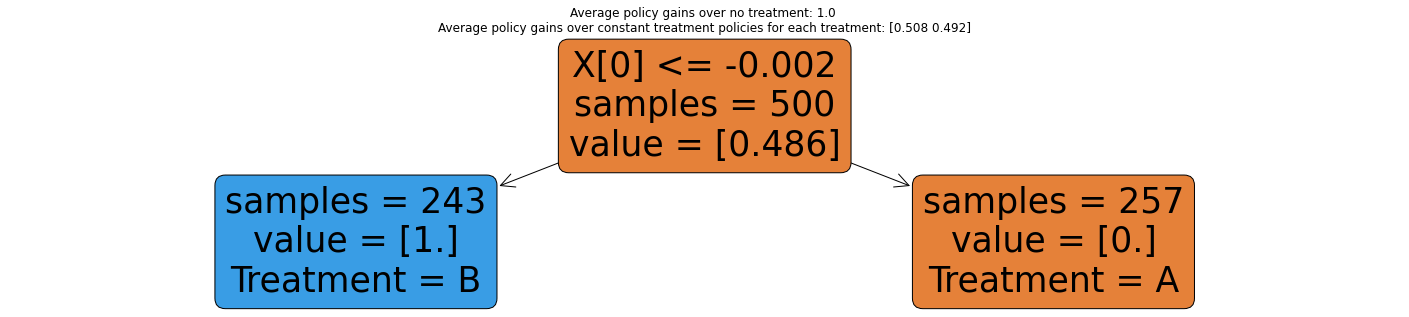

In [7]:
plt.figure(figsize=(25, 5))
est.plot(treatment_names=['A', 'B'])

In [8]:
est = PolicyForest(honest=True).fit(X, y)

In [9]:
est.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

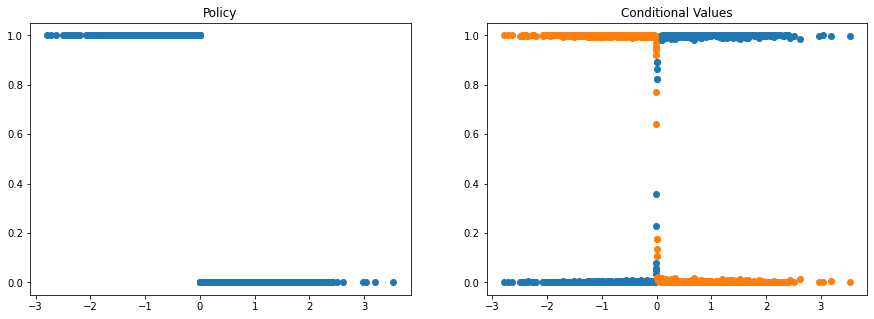

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Policy')
plt.scatter(X[:, 0], est.predict(X))
plt.subplot(1, 2, 2)
plt.title('Conditional Values')
plt.scatter(X[:, 0], est.predict_value(X)[:, 0])
plt.scatter(X[:, 0], est.predict_value(X)[:, 1])
plt.show()

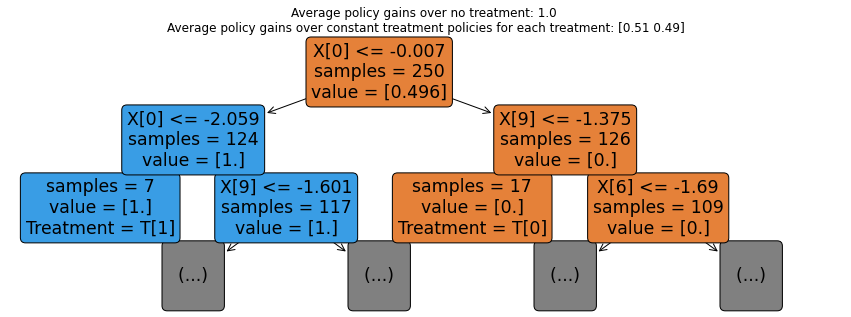

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
est[0].plot(max_depth=2)
plt.show()

# Using Them for CATE Policy Interpretation

We can use the `PolicyTree` to interpret a CATE model, in terms of actionable insights. This functionality is wrapped in the `SingleTreePolicyInterpreter` class.

In [12]:
from econml.cate_interpreter import SingleTreePolicyInterpreter, SingleTreeCateInterpreter

In [13]:
X = np.random.normal(size=(1000, 10))
T = np.random.binomial(2, .5, size=(1000,))
y = (X[:, 0]) * (T==1) + (-X[:, 0]) * (T==2) 

In [14]:
from econml.dml import LinearDML
est = LinearDML(discrete_treatment=True, linear_first_stages=False).fit(y, T, X=X)

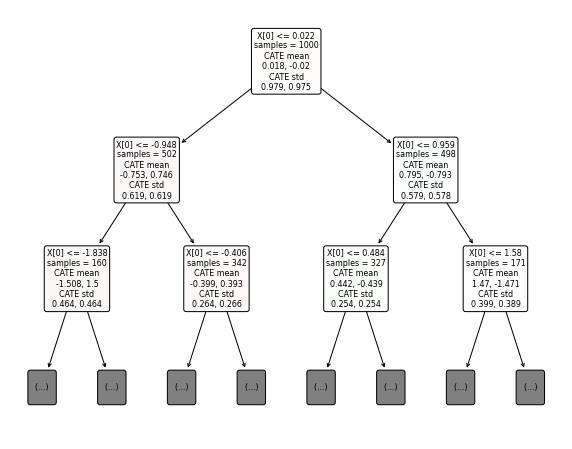

In [15]:
intrp = SingleTreeCateInterpreter()
intrp.interpret(est, X)
plt.figure(figsize=(10, 8))
intrp.plot(max_depth=2, treatment_names=['A', 'B'])
plt.show()

In [16]:
intrp = SingleTreePolicyInterpreter(max_depth=2, min_impurity_decrease=.001)
intrp.interpret(est, X, sample_treatment_costs=.2 * np.ones((X.shape[0], 2)))

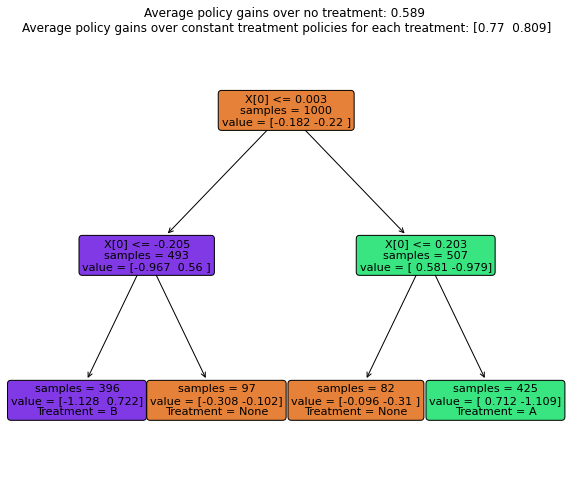

In [17]:
plt.figure(figsize=(10, 8))
intrp.plot(treatment_names=['None', 'A', 'B'])
plt.show()

# StandAlone Policy Learning

We can also learn optimal policies directly from data without the need to train a CATE model first. This is achieved by our `DRPolicyTree` and `DRPolicyForest`, which trains a `PolicyTree` and `PolicyForest` correspondingly, on the doubly robust counterfactual outcome targets. This is the policy learning analogoue of the `DRLearner`, but rather than now trying to learn a good model of the treatment effect heterogeneity, we are learning a good treatment policy directly.

In [18]:
from econml.policy import DRPolicyTree, DRPolicyForest

In [19]:
import numpy as np

X = np.random.normal(size=(1000, 10))
T = np.random.binomial(2, .5, size=(1000,))
y = (X[:, 0]) * (T==1) + (-X[:, 0]) * (T==2) + np.random.normal(0, 2, size=(1000,))

In [20]:
est = DRPolicyTree(max_depth=2, min_impurity_decrease=0.01, honest=True)

In [21]:
est.fit(y, T, X=X)

In [22]:
est.policy_model

PolicyTree(max_depth=2, max_features='auto', min_impurity_decrease=0.01,
           min_samples_split=5)

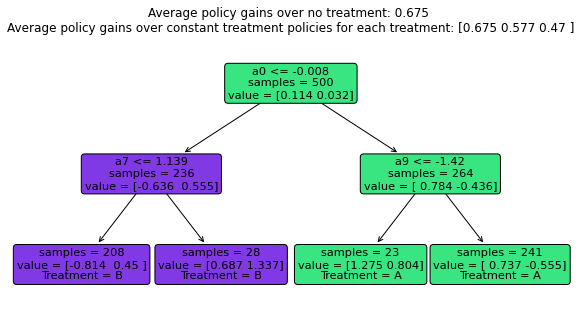

In [23]:
plt.figure(figsize=(10,5))
est.plot(treatment_names=['None', 'A', 'B'], feature_names=['a'+str(i) for i in range(10)])

In [24]:
est.feature_importances_

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.51732385e-16])

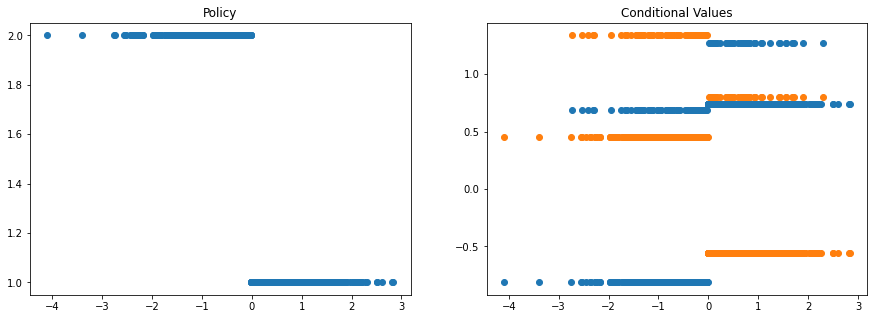

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Policy')
plt.scatter(X[:, 0], est.predict(X))
plt.subplot(1, 2, 2)
plt.title('Conditional Values')
plt.scatter(X[:, 0], est.predict_value(X)[:, 0])
plt.scatter(X[:, 0], est.predict_value(X)[:, 1])
plt.show()

In [26]:
est = DRPolicyForest(n_estimators=1000,
                     max_depth=2, 
                     min_samples_leaf=50,
                     max_samples=.8,
                     honest=True,
                     min_impurity_decrease=0.01,
                     random_state=123)
est.fit(y, T, X=X)

In [27]:
est.feature_importances_

array([ 9.96969263e-01,  2.32169119e-18,  1.55292482e-03,  3.67809685e-04,
       -6.87110863e-19,  1.42135376e-04,  4.70269278e-04,  9.98701792e-05,
        2.34911653e-04,  1.62815868e-04])

In [28]:
est.policy_model

PolicyForest(max_depth=2, max_samples=0.8, min_impurity_decrease=0.01,
             min_samples_leaf=50, min_samples_split=5, random_state=123)

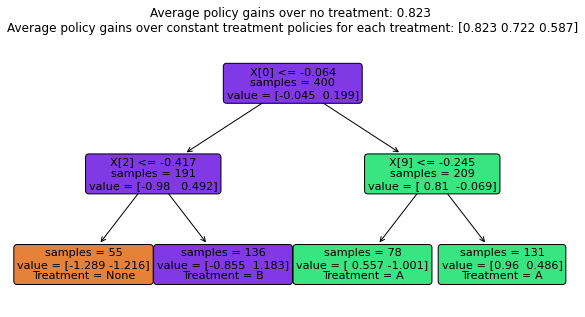

In [29]:
plt.figure(figsize=(10,5))
est.plot(0, treatment_names=['None', 'A', 'B'])

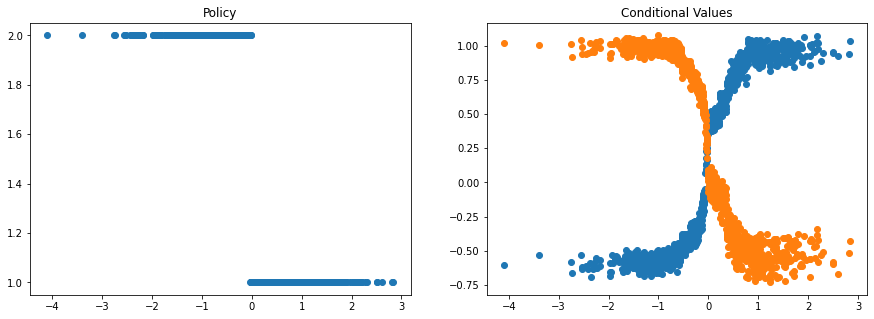

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Policy')
plt.scatter(X[:, 0], est.predict(X))
plt.subplot(1, 2, 2)
plt.title('Conditional Values')
plt.scatter(X[:, 0], est.predict_value(X)[:, 0])
plt.scatter(X[:, 0], est.predict_value(X)[:, 1])
plt.show()